# **Data Wrangling and Analysis for  "WeRateDogs" Tweets**

### by Yuxiang Wu

## **Table of Contents**
- [Introduction](#intro)
- [Data Gathering](#gather)
- [Data Assessing](#assess)
    - [Quality Issues Summary](#quality)
    - [Tidiness Issues Summary](#tidiness)
- [Data Cleaning](#clean)
- [Analyzing & Visualizing Data](#analyze)

<a id='intro'></a>
## **Introduction**

WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. WeRateDogs usually give ratings with a denominator of 10 and a numerator greater than 10, making a key feature of the Twitter account. So far, WeRateDogs has over 8 million followers and has received media coverages in many countries.

In this project, I will be using Python and its libraries to gather, access, and clean the dataset collected from over 5000 WeRateDogs tweets. My goal is to create interesting and trustworthy analyses and visualization by wrangling the essential data from the dataset.

The initial data will be collected from three different sources. A csv file called twitter_archive_enhanced, which contains basic and raw information, is provided directly by the Udacity student online portal. An Udacity employee has run every image in the WeRateDogs Twitter archive through a neural network that can classify dogs' breeds, resulting in a dataset full of image predictions. The image prediction file will be download through a provided url. Finally, the historical data of retweet counts and favourite counts will be collected through Twitter API.

Based on the project context, I have generated a few questions for analysis.
1. How well does 'WeRateDogs' perform over time?
2. Do twitter users prefer 'retweet' or 'like' when they favour a dog tweet?
3. What ratings do dogs usually receive?
4. What are the top 10 common predicted dog breeds on WeRateDogs?
5. How confident was the dog breed prediction?

***

<a id='gather'></a>
## **Gathering Data**

In [1]:
# import python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import tweepy
import json

###### Import provided Twitter archive csv file 

In [2]:
# load existing csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

###### Import the image predictions file from provided url

In [3]:
# download file programatically from url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

# load extracted data into a dataframe
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t')

###### Import API data from Twitter

In [4]:
# set up API authentication pieces
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [5]:
# To collect status data through Twitter, we first need to find out if all tweet ids in 
# twitter's API match with with the  twitter_archive file, and then read and store the data

# create empty arrays to store the data
api_data_to_copy = []
api_id_in_archive = []
api_id_notin_archive = []

# start the timer (optional)
start = time.time()

# read and load data from api
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweets = api.get_status(tweet_id,
                               tweet_mode = 'extended',
                               wait_on_rate_limit = True,
                               wait_on_rate_limit_notify = True)._json
        api_data_to_copy.append(tweets)
        api_id_in_archive.append(tweet_id)
    except:
        api_id_notin_archive.append(tweet_id)
        # print out ids that are not in twitter_archive
        print(tweet_id)

# end the timer (optinal)
end = time.time()
print(end - start)

Rate limit reached. Sleeping for: 367
888202515573088257
873697596434513921
872668790621863937
872261713294495745
869988702071779329
866816280283807744
861769973181624320
856602993587888130
851953902622658560
845459076796616705
844704788403113984
842892208864923648
837366284874571778
837012587749474308
829374341691346946
827228250799742977
812747805718642688
802247111496568832
779123168116150273
775096608509886464
771004394259247104
770743923962707968
759566828574212096
Rate limit reached. Sleeping for: 737
754011816964026368
680055455951884288
Rate limit reached. Sleeping for: 736
2283.0036129951477


In [6]:
# move data from API into a dataframe
tweet_json = pd.DataFrame(api_data_to_copy)

# check data type in the dataset
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2331 non-null object
display_text_range               2331 non-null object
entities                         2331 non-null object
extended_entities                2059 non-null object
favorite_count                   2331 non-null int64
favorited                        2331 non-null bool
full_text                        2331 non-null object
geo                              0 non-null object
id                               2331 non-null int64
id_str                           2331 non-null object
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null obj

In [7]:
# select the data of interest from the above dataset
tweet_json = tweet_json[['id', 'retweet_count','favorite_count' ]]

# check for selection
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [8]:
# save the created dataframe as a csv file
tweet_json.to_csv('tweet_json.txt', encoding = 'utf-8', index = False)

***

<a id='assess'></a>
## Assessing Data

In [1]:
# import python libraries and all three dataframes again
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import requests
import tweepy
import time
import json
import os
import re

twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t')
twitter_api = pd.read_csv('tweet_json.txt', encoding = 'utf-8')

###### Twitter archive dataset

In [2]:
# visually inspect the data
twitter_archive.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2339,666102155909144576,NaN,NaN,2015-11-16 03:55:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my. Here you are seeing an Adobe Setter giv...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666102155...,11,10,None,None,None,None,None
712,784431430411685888,NaN,NaN,2016-10-07 16:33:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stormy. He's curly af. Already pupared...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/784431430...,12,10,Stormy,None,None,None,None


<span style="color:blue">Observations</span>
- <span style="color:blue">Missing stage information: 'None' for 'doggo', 'floofer', 'pupper', and 'puppo'.</span>
- <span style="color:blue">It'd be not easy to analyze timestamp for its long format</span>
- <span style="color:blue">Can't read the entire string in 'source' and 'text'</span>
- <span style="color:blue">Missing information for some columns (i.e. 'NaN)</span>

In [3]:
# check dog stages
twitter_archive.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


<span style="color:blue">Observations</span>
- <span style="color:blue">There are 1 tweet has both 'doggo' and 'puppo' </span>
- <span style="color:blue">There are 12 tweets have both 'doggo' and 'pupper' </span>
- <span style="color:blue">There are 1 tweet has both 'doggo' and 'floofer' </span>

In [4]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<span style="color:blue">Observations</span>
- <span style="color:blue">missing expanded_urls (2297 vs. 2356). Each tweet should have a unique url</span>
- <span style="color:blue">Erroneous datatypes</span>
    - <span style="color:blue">'in_reply_to_status_id' should be integer instead of float</span>
    - <span style="color:blue">'in_reply_to_user_id' should be integer instead of float</span>
    - <span style="color:blue">'timestamp' should be DateTime instead of 'object'</span>
    - <span style="color:blue">'retweeted_status_id' should be integer instead of float</span>
    - <span style="color:blue">'retweeted_status_user_id' should be integer instead of float</span>
    - <span style="color:blue">'retweeted_status_timestamp' should be DateTime instead of 'object'</span>

In [5]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

<span style="color:blue">Observations</span>
- <span style="color:blue"> Retweets exist in the data set, which we don't want for this analysis </span>
    - <span style="color:blue">'retweeted_status_id' should be 0 instead of 181 unique values</span>
    - <span style="color:blue">'retweeted_status_user_id' should be 0 instead of 25 unique values</span>
    - <span style="color:blue">'retweeted_status_timestamp' should be 0 instead of 181 unique values</span>
- <span style="color:blue">There should be only one unique value for the rating_denominator, which is '10'. We will take a closer look at the ratings </span>
- <span style="color:blue">Four columns (doggo, floofer, pupper, puppo) contain the same variable information</span>

In [6]:
# check the rating denominators
print(twitter_archive['rating_denominator'].value_counts().index.tolist())

[10, 11, 50, 80, 20, 2, 16, 40, 70, 15, 90, 110, 120, 130, 150, 170, 7, 0]


<span style="color:blue">Observations</span>
- <span style="color:blue"> Invalid denominators (values other than 10)</span>

In [7]:
# check the rating numerators
print(twitter_archive['rating_numerator'].value_counts().index.tolist())

[12, 11, 10, 13, 9, 8, 7, 14, 5, 6, 3, 4, 1, 2, 420, 0, 15, 75, 80, 20, 24, 26, 44, 50, 60, 165, 84, 88, 144, 182, 143, 666, 960, 1776, 17, 27, 45, 99, 121, 204]


<span style="color:blue">Observations</span>
- <span style="color:blue"> Invalid numerators (large values such as 1776 and 666)</span>

In [8]:
# check the names
twitter_archive['name'].value_counts().sort_index()

Abby             2
Ace              1
Acro             1
Adele            1
Aiden            1
Aja              1
Akumi            1
Al               1
Albert           2
Albus            2
Aldrick          1
Alejandro        1
Alexander        1
Alexanderson     1
Alf              1
Alfie            5
Alfy             1
Alice            2
Amber            1
Ambrose          1
Amy              1
Amélie           1
Anakin           2
Andru            1
Andy             1
Angel            1
Anna             1
Anthony          1
Antony           1
Apollo           1
                ..
Ziva             1
Zoe              1
Zoey             3
Zooey            1
Zuzu             1
a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old         

<span style="color:blue">Observations</span>
- <span style="color:blue">Inaccurate names such as 'a', 'an', 'by','very'</span>
- <span style="color:blue">Values with the first letter capitalized are more likely actual names</span> 

###### Image prediction data

In [9]:
# visually inspect the data
image_prediction.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1782,828770345708580865,https://pbs.twimg.com/media/C4BiOXOXAAAf6IS.jpg,1,seat_belt,0.765979,False,Chesapeake_Bay_retriever,0.033899,True,polecat,0.027252,False
1514,786664955043049472,https://pbs.twimg.com/media/CurLmoqXgAEPoJ-.jpg,1,Leonberg,0.512034,True,keeshond,0.464816,True,Pomeranian,0.007812,True
1512,786363235746385920,https://pbs.twimg.com/media/Cum5LlfWAAAyPcS.jpg,1,golden_retriever,0.929266,True,Labrador_retriever,0.062867,True,Saluki,0.002157,True


<span style="color:blue">Observations</span>
- <span style="color:blue"> Dog breeds' names are not consistently in upper or lowercase for p1, p2, and p3</span>

In [10]:
image_prediction.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

<span style="color:blue">Observations</span>
- <span style="color:blue">missing information (2075 tweet_id vs. 2356 tweet id in the tweet_archive data)</span>
- <span style="color:blue">missing image (2009 jpg_url vs. 2075 tweet id)</span>

In [11]:
# check if there is any duplicated tweet_id
sum(image_prediction['tweet_id'].duplicated())

0

In [12]:
# check if there is any duplicated url
sum(image_prediction['jpg_url'].duplicated())

66

<span style="color:blue">Observations</span>
- <span style="color:blue">there are 66 possible retweets</span>

In [13]:
# check p1 values
image_prediction['p1'].value_counts().sort_index()

Afghan_hound                       4
African_crocodile                  1
African_grey                       1
African_hunting_dog                1
Airedale                          12
American_Staffordshire_terrier    13
American_black_bear                1
Angora                             2
Appenzeller                        2
Arabian_camel                      3
Arctic_fox                         4
Australian_terrier                 2
Bedlington_terrier                 5
Bernese_mountain_dog              10
Blenheim_spaniel                  11
Border_collie                     12
Border_terrier                     7
Boston_bull                        9
Brabancon_griffon                  3
Brittany_spaniel                   7
Cardigan                          19
Chesapeake_Bay_retriever          23
Chihuahua                         83
Christmas_stocking                 3
Dandie_Dinmont                     6
Doberman                           8
Egyptian_cat                       1
E

<span style="color:blue">Observations</span>
- <span style="color:blue">Inaccurate dog breeds' names such as web_site and vacuum</span>
- <span style="color:blue">Non-meaningful column name p1 </span>

###### Twitter api data

In [14]:
# visually inspect data
twitter_api.sample(3)

,id,retweet_count,favorite_count
790,771380798096281600,5149,10579
1524,689275259254616065,243,1140
1364,700462010979500032,1777,4109


In [15]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


In [16]:
twitter_api.nunique()

id                2331
retweet_count     1694
favorite_count    1982
dtype: int64

In [17]:
# check number of null value
twitter_api.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

<span style="color:blue">Observations</span>
- <span style="color:blue">Missing tweets (2331 id vs. 2356 tweet ids in the tweet_archive dataset)</span>
- <span style="color:blue">Inconsistent column name (id vs. tweet_id)</span>

<a id='quality'></a>
### Quality Issues Summary

*Invalid information*
- Multiple dog stages in one tweet in twitter_archive
- Invalid denominators in twitter_archive(values other than 10)
- Invalid numerators in twitter_archive(large values such as 1776 and 666)

*Inaccurate information*
- Retweets exist in twitter_archive, which we don't want for this analysis
- Inaccurate names in twitter_archive such as 'a', 'an', 'by','very'
- there are 66 possible retweets in image_predition
- Inaccurate dog breeds' names in image_predition such as web_site and vacuum
- Non-meaningful column name p1 in image_predition

*Erroneous datatypes*
- 'in_reply_to_status_id' should be integer instead of float
- 'in_reply_to_user_id' should be integer instead of float
- 'timestamp' should be DateTime instead of 'object'
- 'retweeted_status_id' should be integer instead of float
- 'retweeted_status_user_id' should be integer instead of float
- 'retweeted_status_timestamp' should be DateTime instead of 'object'

*Missing information*
- Missing stage information in twitter_archive: 'None' for 'doggo', 'floofer', 'pupper', and 'puppo'
- Missing information for some columns in twitter_archive(ie. 'NaN)
- missing expanded_urls in twitter_archive(2297 vs. 2356). Each tweets should have a unique url
- missing imformation in image_predition(2075 tweet_id vs. 2356 tweet id in the tweet_archive data)
- missing image in image_predition(2009 jpg_url vs. 2075 tweet id)
- Missing tweets in twitter_api (2331 id vs. 2356 tweet ids in the tweet_archive dataset)

*Formatting issues*
- It'd be not easy to analyze timestamp for its long format in twitter_archive
- 'source' and 'text' is not clear and readable in twitter_archive
- Dog breeds' names are not consistently in upper or lowercase for p1, p2, and p3 in image_predition
- Inconsistent column name ('id' in twitter_api and 'tweet_id' in other datasets).

<a id='tidiness'></a>
### Tidiness Issues Summary

- 4 columns represent the same variable(dog stage) in twitter_archive: doggo, floofer, pupper, puppo
- All three dataset contains information for each tweet id

***

<a id='clean'></a>
## Cleaning Data

In [18]:
# make copies of all dataframes for cleaning
archive_clean = twitter_archive.copy()
prediction_clean = image_prediction.copy()
api_clean = twitter_api.copy()

***

**Issue 1 (Quality)**: Inconsistent column name ('id' in twitter_api and 'tweet_id' in other datasets).

**Solution**: Change the name 'id' to 'tweet_id'

In [19]:
# CODE
api_clean.rename(columns={"id": "tweet_id"}, inplace=True)

In [20]:
# FINAL TEST
api_clean.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7696,36145


***

**Issue 2 (Tidiness)**: 'twitter_archive', 'image_prediction', and 'Twitter_api' are datasets containing information with respect to each tweet id

**Solution**: combine all three dataframes on 'tweet_id'

In [21]:
# CODE
dummy = pd.merge(left = archive_clean, 
                 right = prediction_clean,
                 left_on = 'tweet_id', 
                 right_on = 'tweet_id', 
                 how = 'inner')

tweets = pd.merge(left = dummy, 
                  right = api_clean,
                  left_on = 'tweet_id', 
                  right_on = 'tweet_id', 
                  how = 'inner')

In [22]:
# FINAL TEST
tweets.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

***

**Issue 3 (Quality)**: Multiple dog stages in one tweet in twitter_archive

**Solution**: Replace the multiple dog stages with 'None'

In [23]:
# TEST
# check how many tweets have multiple dog stages
tweets.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1741
1,None,None,None,puppo,23
2,None,None,pupper,None,210
3,None,floofer,None,None,7
4,doggo,None,None,None,65
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,11
7,doggo,floofer,None,None,1


In [24]:
# CODE
# extract the index number for tweets that have multiple dog stages
doggo_puppo_index = tweets.loc[(tweets['doggo'] == 'doggo') & (tweets['puppo'] == 'puppo')].index.values
doggo_pupper_index = tweets.loc[(tweets['doggo'] == 'doggo') & (tweets['pupper'] == 'pupper')].index.values
doggo_floofer_index = tweets.loc[(tweets['doggo'] == 'doggo') & (tweets['floofer'] == 'floofer')].index.values

# place all index number in an array
id_array = np.concatenate([doggo_puppo_index, doggo_pupper_index, doggo_floofer_index])

# replace the multiple dog stages with 'None'
for i in id_array:
    tweets.loc[i, 'doggo'] = 'None'
    tweets.loc[i, 'floofer'] = 'None'
    tweets.loc[i, 'pupper'] = 'None'
    tweets.loc[i, 'puppo'] = 'None'

In [25]:
# FINAL TEST
tweets.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1754
1,None,None,None,puppo,23
2,None,None,pupper,None,210
3,None,floofer,None,None,7
4,doggo,None,None,None,65


***

**Issue 4 (Tidiness)**: 4 columns represent the same variable(dog stage): doggo, floofer, pupper, puppo

**Solution**:combine the 4 columns into a variable column 'dag_stage'

In [26]:
# CODE
# make a ssubset of data only contains dog stage information
stage_only = tweets[['doggo', 'floofer', 'pupper', 'puppo']]

# replace all the 'None's with empty string
stage_replace = stage_only.replace(to_replace ='None', value ='') 

# create a new column 'dog_stage' in the tweets dataframe
tweets['dog_stage'] = stage_replace.doggo + stage_replace.floofer + stage_replace.pupper + stage_replace.puppo

# drop the original dog stage columns 
tweets = tweets.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [27]:
# FINAL TEST
tweets.groupby(['dog_stage']).size()

dog_stage
           1754
doggo        65
floofer       7
pupper      210
puppo        23
dtype: int64

***

**Issue 5 (Quality)**: Retweets exist in data based on the following findings
- 'retweeted_status_id' should be Null or NaN instead of 181 unique values
- 'retweeted_status_user_id' should be null or NaN instead of 25 unique values
- 'retweeted_status_timestamp' should be null or Nan instead of 181 unique values
- 66 retweets exist in the dataset (duplicated jpg_url)

**Solution**: Remove all the retweets

In [28]:
# CODE
# keep data where the 'retweeted_status_id' is NaN
tweets = tweets[np.isnan(tweets.retweeted_status_id)]

# remove rows that have duplicated jpg_url
tweets.drop_duplicates(subset = 'jpg_url', keep = 'first', inplace = True)

In [29]:
# FINAL TEST 1
tweets[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 3 columns):
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
dtypes: float64(2), object(1)
memory usage: 62.1+ KB


In [30]:
# FINAL TEST 2
sum(tweets['jpg_url'].duplicated())

0

In [31]:
# FINAL TEST 3
tweets['jpg_url'].nunique()

1987

***

**Issue 6 (Quality)**: Invalid information: 
- Invalid denominators (values other than 10)
- Invalid numerators (large values such as 1776 and 666)

**Solution**:
- create a new column to show integer ratings which their default denominators are 10
- delete the original rating numerator and denominator columns

In [32]:
# CODE 1
# source: https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers

# since we have removed some rows previously, reset the index for further analysis
tweets = tweets.reset_index(drop=True)

# create empty arrays to store the ratings that have decimal numbers
rating_decimal_numerator = []
rating_decimal_denominator = []
rating_decimal_index = []
rating_decimal_text = []

# read through the string in each tweet and search for rating with decimal
# store the found decimal ratings into the empty arrays
for i, text in tweets['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        rating_decimal_index.append(i)
        rating_decimal_text.append(text)
        rating_decimal_numerator.append((re.search('\d+\.\d+\/\d+', text).group()).split('/', 1)[0])
        rating_decimal_denominator.append((re.search('\d+\.\d+\/\d+', text).group()).split('/', 1)[1])
        
# change the extracted strings to floats and store them as numpy arrays
rating_decimal_numerator = np.array([float(k) for k in rating_decimal_numerator])
rating_decimal_denominator = np.array([float(k) for k in rating_decimal_denominator])
rating_decimal_index = np.array(rating_decimal_index)

# check if ratings with decimal numbers are captured  
rating_decimal_text

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [33]:
# CODE 2
# create empty arrays to store all the ratings as integers
rating_int_numerator = []
rating_int_denominator = []
rating_int_index = []

# read through the string in each tweet and search for fractional slash
# store the found ratings into the empty arrays
# if a decimal rating found (eg. 9.75/10), raiting_int_numerator will be 75, and raiting_int_denominator will be 10
for i, text in tweets['text'].iteritems():
    if bool(re.search('\d+\/\d+', text)):
        rating_int_numerator.append((re.search('\d+\/\d+', text).group()).split('/', 1)[0])
        rating_int_denominator.append((re.search('\d+\/\d+', text).group()).split('/', 1)[1])
        rating_int_index.append(i)

# change the extracted strings to floats and store them as numpy arrays
rating_int_numerator = np.array([float(i) for i in rating_int_numerator])
rating_int_denominator = np.array([float(i) for i in rating_int_denominator])
rating_int_index = np.array(rating_int_index)

# raiting_int_index includes rating_decimal_index
# so find out the index exist in both arrays because 
# for a same index, it will show 75 in rating_int_numerator (wrong) and 9.75 in rating_decimal_numerator (correct)
to_delete = np.intersect1d(rating_decimal_index, rating_int_index)
to_delete

array([  39,  499,  548, 1368])

In [34]:
# CODE 3
# delete ratings that are incorrectly extracted
rating_int_numerator = np.delete(rating_int_numerator, to_delete)
rating_int_denominator = np.delete(rating_int_denominator, to_delete)
rating_int_index = np.delete(rating_int_index, to_delete)

# confirm both arrays do not share same index
np.intersect1d(rating_decimal_index, rating_int_index)

array([], dtype=int64)

In [35]:
# CODE 4
# create three arrays containing all the ratings wrt. numerator, denominator, and index
rating_numerator_new = np.concatenate([rating_decimal_numerator, rating_int_numerator])
rating_denominator_new = np.concatenate([rating_decimal_denominator, rating_int_denominator])
rating_index_new = np.concatenate([rating_decimal_index, rating_int_index])

# convert all the ratings to 10 rating scale
rating_new = np.rint(rating_numerator_new * 10 / rating_denominator_new)

# place the converted ratings in a dataframe
rating_data = {'new_rating' : pd.Series(rating_new, index = rating_index_new)}
rating_data = pd.DataFrame(rating_data) 
rating_data.sort_index(inplace=True)
rating_data['new_rating'] = rating_data['new_rating'].apply(np.int64)

# delete tweets that have invalid ratings (too large or too small)
tweets = tweets.merge(rating_data, left_index=True, right_index=True)
tweets = tweets.drop(tweets[(tweets['new_rating'] > 20) | (tweets['new_rating'] < 1)].index)

# reset the dataframe index for further analysis
tweets = tweets.reset_index(drop=True)
tweets = tweets.drop(['rating_numerator', 'rating_denominator', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [36]:
# FINAL TEST
print(tweets['new_rating'].value_counts().index.tolist())

[12, 10, 11, 13, 9, 8, 7, 14, 6, 5, 3, 4, 2, 1]


***

**Issue 7 (Quality)**: 'source' is not clear and readable in twitter_archive

**Solution**: Extract 'Twitter for iPhone' from the entire string and replace the original string in the source column

In [37]:
# CODE
# source: Hands-on Exploratory Data Analysis with Python by S.Mukhiya and U.Ahmed
# extract the desired words and replace the entire string in the 'source' column
tweets['source'] = tweets['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [38]:
# FINAL TEST
tweets.source.sample(5)

1320    Twitter for iPhone
1003    Twitter for iPhone
1912    Twitter for iPhone
1136    Twitter for iPhone
823     Twitter for iPhone
Name: source, dtype: object

***

**Issue 8 (Quality)**: Some columns are not needed for the analysis

**Solution**: Drop the undesired columns

In [39]:
# TEST
tweets.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'name', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweet_count', 'favorite_count', 'dog_stage', 'new_rating'],
      dtype='object')

In [40]:
# CODE
# keep the desired columns
tweets = tweets[['tweet_id', 'timestamp', 'source', 'name', 'p1', 'p1_dog', 'p1_conf', 'retweet_count', 'favorite_count', 'dog_stage', 'new_rating', 'jpg_url', 'text']]
pd.set_option('display.max_columns', None)

In [41]:
# FINAL TEST
tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'name', 'p1', 'p1_dog', 'p1_conf',
       'retweet_count', 'favorite_count', 'dog_stage', 'new_rating', 'jpg_url',
       'text'],
      dtype='object')

***

**Issue 9 (Quality)** Datatype issue - some columns are in wrong datatypes

**Solution**: Change columns to correct datatypes

In [42]:
# TEST
# check datatypes
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 13 columns):
tweet_id          1982 non-null int64
timestamp         1982 non-null object
source            1982 non-null object
name              1982 non-null object
p1                1982 non-null object
p1_dog            1982 non-null bool
p1_conf           1982 non-null float64
retweet_count     1982 non-null int64
favorite_count    1982 non-null int64
dog_stage         1982 non-null object
new_rating        1982 non-null int64
jpg_url           1982 non-null object
text              1982 non-null object
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 187.8+ KB


In [43]:
# CODE
tweets['timestamp'] = pd.to_datetime(tweets.timestamp)
tweets['source'] = tweets['source'].astype('category')
tweets['dog_stage'] = tweets['dog_stage'].astype('category')

In [44]:
# FINAL TEST
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Data columns (total 13 columns):
tweet_id          1982 non-null int64
timestamp         1982 non-null datetime64[ns]
source            1982 non-null category
name              1982 non-null object
p1                1982 non-null object
p1_dog            1982 non-null bool
p1_conf           1982 non-null float64
retweet_count     1982 non-null int64
favorite_count    1982 non-null int64
dog_stage         1982 non-null category
new_rating        1982 non-null int64
jpg_url           1982 non-null object
text              1982 non-null object
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 161.0+ KB


***

**Issue 10 (Quality)**: Inaccurate names in twitter_archive such as 'a', 'an', 'by','very'. Based on the previous visual inspection, names with the first letter capitalized are more likely actual names

**Solution**: Replace all inaccurate names with NaNs

In [45]:
# CODE
# Store all names with first letter in lowercase in a list
lowercase_name = []
for name in tweets['name']:
    if name[0].islower() and name not in lowercase_name:
        lowercase_name.append(name)

# replace all names with first letter in lowercase with NaN
tweets['name'] = tweets['name'].replace(lowercase_name, np.nan)
# replace 'None' with NaN
tweets['name'] = tweets['name'].replace('None', np.nan)

In [46]:
# FINAL TEST
print(tweets['name'].value_counts().index.tolist())

['Oliver', 'Charlie', 'Cooper', 'Penny', 'Tucker', 'Lucy', 'Sadie', 'Winston', 'Lola', 'Toby', 'Daisy', 'Jax', 'Koda', 'Stanley', 'Bella', 'Bo', 'Chester', 'Louis', 'Scout', 'Bailey', 'Leo', 'Rusty', 'Buddy', 'Oscar', 'Dave', 'Milo', 'Jerry', 'Larry', 'Bentley', 'Jack', 'Gary', 'Derek', 'Archie', 'George', 'Oakley', 'Maggie', 'Clarence', 'Cassie', 'Dexter', 'Alfie', 'Brody', 'Winnie', 'Finn', 'Chip', 'Bear', 'Duke', 'Gus', 'Sophie', 'Clark', 'Phil', 'Scooter', 'Reese', 'Bruce', 'Moose', 'Loki', 'Nala', 'Earl', 'Reggie', 'Kyle', 'Jimothy', 'Wilson', 'Sebastian', 'Louie', 'Wallace', 'Vincent', 'Steven', 'Samson', 'Malcolm', 'Zoey', 'Zeke', 'Riley', 'Jeffrey', 'Shadow', 'Rosie', 'Otis', 'Waffles', 'Wyatt', 'Max', 'Walter', 'Sunny', 'Mia', 'Boomer', 'Gizmo', 'Olive', 'Ruby', 'Calvin', 'Beau', 'Ellie', 'Hank', 'Gerald', 'Lily', 'Ollie', 'Romeo', 'Aspen', 'Odie', 'Benedict', 'Sammy', 'Terry', 'Wally', 'Axel', 'Maxaroni', 'Piper', 'Yogi', 'Atlas', 'Sampson', 'Fiona', 'Dash', 'Sandy', 'Indie',

***

**Issue 11 (Quality)**: Non-meaningful column names: p1 and p1_dog

**Solution**: Rename p1 as predicted_breed and p1_dog as prediction_success

In [47]:
# CODE 
tweets.rename(columns = {'p1': 'predicted_breed', 
                         'p1_dog': 'prediction_success', 
                         'p1_conf': 'prediction_cl'}, inplace=True)

In [48]:
# FINAL TEST
tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'name', 'predicted_breed',
       'prediction_success', 'prediction_cl', 'retweet_count',
       'favorite_count', 'dog_stage', 'new_rating', 'jpg_url', 'text'],
      dtype='object')

***

## Storing Cleaned Data

In [49]:
tweets.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

***

<a id='analyze'></a>
## Analyzing & Visualizing Data

In [1]:
# import python libraries and the master file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import requests
import tweepy
import time
import json
import os
import re
from IPython.display import Image
 
working_data = pd.read_csv('twitter_archive_master.csv', encoding = 'utf-8')

In [2]:
# check the dataset
working_data.sample(2)

,tweet_id,timestamp,source,name,predicted_breed,prediction_success,prediction_cl,retweet_count,favorite_count,dog_stage,new_rating,jpg_url,text
1375,680100725817409536,2015-12-24 19:00:23,TweetDeck,NaN,golden_retriever,True,0.698961,1360,3544,pupper,11,https://pbs.twimg.com/media/CW-loUBWYAAn2Cb.jpg,This pupper is not coming inside until she cat...
359,813217897535406080,2016-12-26 03:00:30,Twitter for iPhone,Atlas,Samoyed,True,0.905972,7438,18934,NaN,13,https://pbs.twimg.com/media/C0khWkVXEAI389B.jpg,Here is Atlas. He went all out this year. 13/1...


***

### Question 1. How well does 'WeRateDogs' perform over time?

In [3]:
# find out how many tweets are generated every week
tweets_weekly = working_data.groupby('timestamp').size().reset_index().rename(columns={0: 'tweet_count'})
tweets_weekly.index = pd.DatetimeIndex(tweets_weekly.timestamp) # change index to datetime index
tweets_weekly = tweets_weekly.resample('M').sum()[:-1] # count weekly sweets and drop last row (incase not a full month)
tweets_weekly.reset_index(drop=False, inplace=True)

# find out how many retweets are generated every week
retweets_weekly = working_data[['timestamp', 'retweet_count']]
retweets_weekly.index = pd.DatetimeIndex(retweets_weekly.timestamp) # change index to datetime index
retweets_weekly = retweets_weekly.resample('M').sum()[:-1] # count weekly retweets and drop last row (incase not a full month)
retweets_weekly.reset_index(drop=False, inplace=True)

# find out how many likes are generated every week
favorite_weekly = working_data[['timestamp', 'favorite_count']]
favorite_weekly.index = pd.DatetimeIndex(favorite_weekly.timestamp) # change index to datetime index
favorite_weekly = favorite_weekly.resample('M').sum()[:-1] # count weekly likes and drop last row (incase not a full month)
favorite_weekly.reset_index(drop=False, inplace=True)

# source: https://chrisalbon.com/python/data_wrangling/pandas_group_data_by_time/

Text(0, 0.5, 'counts')

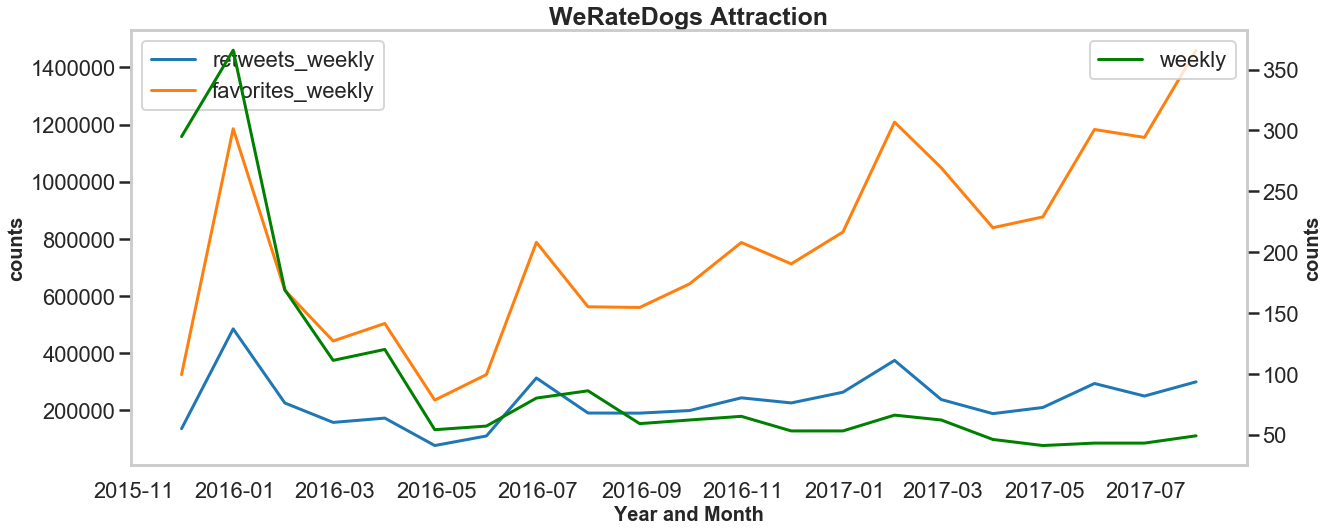

In [4]:
# creat a plot to visulize data
sns.set_context('poster')
sns.set_style("whitegrid", {'axes.grid' : False})

figure, ax1 = plt.subplots(figsize=(20,8))
plt.plot(retweets_weekly.timestamp, retweets_weekly.retweet_count, label='retweets_weekly')
plt.plot(favorite_weekly.timestamp, favorite_weekly.favorite_count, label='favorites_weekly')
plt.title('WeRateDogs Attraction', weight='bold', fontsize=25,)
plt.xlabel('Year and Month', weight='bold', fontsize = 20)
plt.ylabel('counts', weight='bold', fontsize = 20)
plt.legend()

ax2 = plt.twinx()
sns.lineplot(tweets_weekly.timestamp, tweets_weekly.tweet_count, color='g', ax=ax2, label='weekly')
plt.ylabel('counts', weight='bold', fontsize = 20)

### Insight 1: 
*Although WeRateDogs generated fewer tweets gradually since the beginning of 2016, they still received a relatively constant amount of retweets every month. Moreover, the amount of "like"s that WeRateDogs received was steadily going up, which means that every tweet generated by WeRateDogs is getting more retweets and a lot more "like"s over time. Hence, we can conclude that WeRateDogs is gaining more attention from the public. Another way to look at WeRateDogs attraction is to check the historical growth of the number of followers. Since the historical data of followers are not available, I have left it off the discussion.*

***

### Question 2. Do twitter users prefer 'retweet' or 'like' when they favour a dog tweet?

Text(-12.29, 0.5, 'Favorite Count')

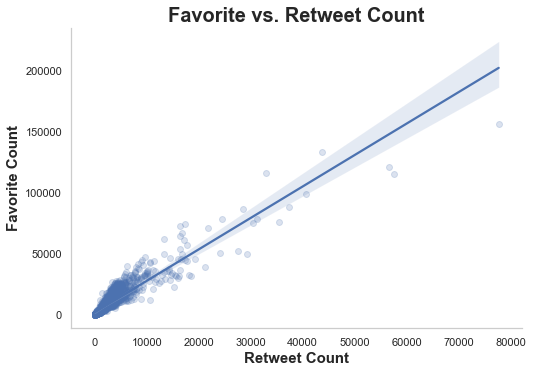

In [5]:
sns.set(color_codes = True)
sns.set_style("whitegrid", {'axes.grid' : False})

sns.lmplot(x = 'retweet_count', 
           y = 'favorite_count', 
           data = working_data, 
           height = 5, 
           aspect = 1.5, 
           scatter_kws = {'alpha':1/5})

plt.title('Favorite vs. Retweet Count', weight='bold', fontsize = 20)
plt.xlabel('Retweet Count', weight='bold', fontsize = 15)
plt.ylabel('Favorite Count', weight='bold', fontsize = 15)

### Insight 2: 
*Each point represents the retweets and likes that one tweet has received at the time this data was collected. It can be seen that the majority of the tweets have received less than 50,000 likes and 10,000 retweets, and the most popular tweet has received over 150,000 likes and approximately 80,000 retweets. Apparently, favourite count and retweet count are highly positively correlated, and for about every 2.5 likes there is 1 retweet.*

***

### Question 3. What ratings do dogs usually receive?

Text(0, 0.5, 'Counts')

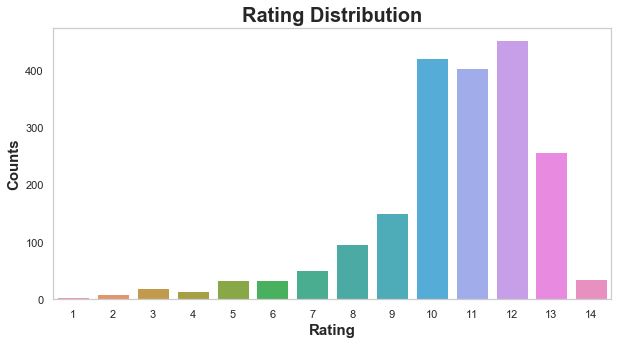

In [6]:
# create a dataframe plotting
rating_count = working_data.groupby(['new_rating']).count()['tweet_id']
rating_plot = pd.DataFrame({'rating':rating_count.index, 'count':rating_count.values})

# use seaborn for plotting
sns.set(rc = {'figure.figsize':(10, 5)})
sns.set(style = 'whitegrid')
sns.set_style('whitegrid', {'axes.grid' : False})
ax = sns.barplot(x = 'rating', y = 'count', data = rating_plot)
plt.title('Rating Distribution', weight = 'bold', fontsize = 20)
plt.xlabel('Rating', weight = 'bold', fontsize = 15)
plt.ylabel('Counts', weight = 'bold', fontsize = 15)

### Insight 3:
*The rating system in WeRateDog does not intend to rate dogs as if the dogs were in a competition. In fact, the Twitter account is devoted to humorously reviewing pictures of dogs doing adorable poses, often giving them scores above 10/10 (https://knowyourmeme.com/memes/theyre-good-dogs-brent). It can be seen that the majority of ratings fall in the 10 to 12 range. Ratings below 5 are rarely given. Let's take a look into a low rated tweet and a high rated tweet, and we may see the difference.* 

In [7]:
# randomly select tweet that have ratings lower or euqal to 1
random_low = working_data.loc[(working_data['new_rating'] <= 1)].sample(1)

# print the picture of the low rated tweet
Image(url = random_low.jpg_url.iloc[0], width = 300, height = 300)

In [8]:
# print the text of the low rated tweet
print(random_low.text.values)

["Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX"]


In [9]:
# randomly select tweet that have ratings higher or euqal to 14
random_high = working_data.loc[(working_data['new_rating'] >= 13)].sample(1)

# print the picture of the high rated tweet
Image(url = random_high.jpg_url.iloc[0], width = 300, height = 300)

In [10]:
# print the text of the high rated tweet
print(random_high.text.values)

['If you are aware of who is making these please let me know. 13/10 vroom vroom https://t.co/U0D1sbIDrG']


***

### Question 4: What are the top 10 common predicted dog breeds on WeRateDogs?

In [11]:
# take a look at what kind of breed we have here
working_data.predicted_breed.value_counts()

golden_retriever      138
Labrador_retriever     93
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
lawn_mower              1
bakery                  1
shield                  1
bannister               1
bighorn                 1
Name: predicted_breed, Length: 372, dtype: int64

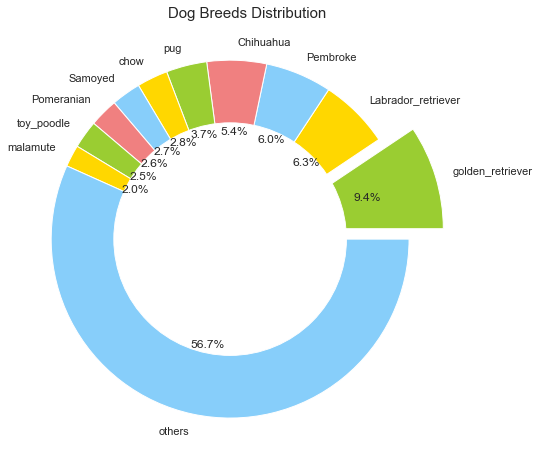

Total dogs: 1469
Total dog breeds: 111


In [12]:
# remove the values that have an invalid dog breeds name such as 'alp' and 'hand_blower'
real_dogs = working_data.loc[(working_data['prediction_success'] == True)].predicted_breed

# create a series to sort the proportions of top 10 breeds and the rest breeds as 'others'
all_breeds = real_dogs.value_counts()
top_breeds = all_breeds.head(10)
if len(all_breeds) > 10:
    top_breeds['others'.format(len(all_breeds) - 10)] = all_breeds[10:].sum()

# convert the series into dataframe
top_breeds = pd.Series.to_frame(top_breeds)
top_breeds = top_breeds.rename_axis('breed').reset_index()
top_breeds.rename(columns={"predicted_breed": "count"}, inplace=True)

# create a donut plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes((0,0,0.5,1))
ax.set_title('Dog Breeds Distribution', bbox={'facecolor':'1', 'pad':5}, size=15)
labels = top_breeds['breed']
sizes = top_breeds['count']
colors = ['yellowgreen', 
          'gold', 
          'lightskyblue', 
          'lightcoral', 
          'yellowgreen', 
          'gold', 
          'lightskyblue', 
          'lightcoral', 
          'yellowgreen', 
          'gold', 
          'lightskyblue']
explode = (0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0) 
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False)     

#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.65, color='white', fc='white',linewidth=0.9)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

print('Total dogs: {}'.format(len(real_dogs)))
print('Total dog breeds: {}'.format(len(all_breeds))) 

# source: https://stackoverflow.com/questions/29219055/plot-top-10-verse-all-other-values

### Insight 4:
*The machine learning tool developed by Udacity staff has successfully identified 111 dog breeds for 1469 dogs at the time this data was collected. It can be seen that the most popular dog breed on WeRateDogs is golden retriever, which accounts for 9.4 percent of the dogs. Breeds that are not the 10 most common are grouped as 'others', and each of these breeds make up less than 2% of the dog population. The good spread of dog breeds distribution shows that WeRateDogs successfully captured attention from pet owners of most kinds of dogs.*


*The machine learning tool uses dog pictures to make predictions, and the promising conclusion above really depends on how useful the machine learning tool is at recognizing different kinds of dogs. Thus, my question is how confident we are with the prediction.*

*** 

### Question 5: How confident was the dog breed prediction?

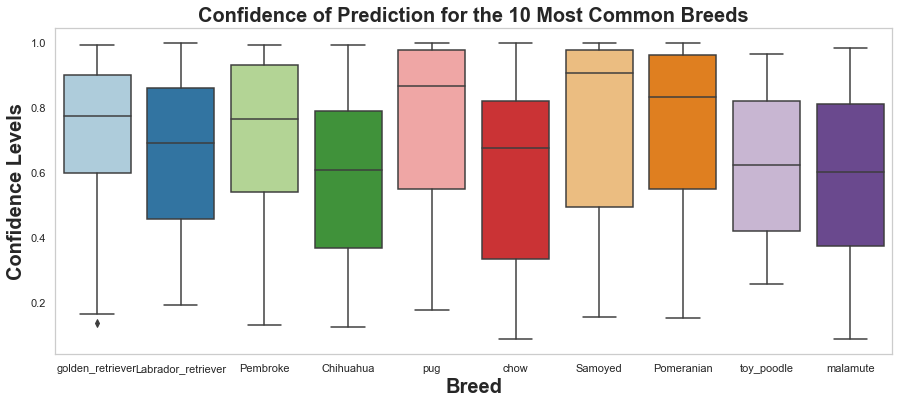

In [13]:
# create a list of 10 most common breeds
common_breeds = real_dogs.value_counts().head(10).index.tolist()

# extract the confidence levels associated with the sucessful prediction 
df_cl = working_data[working_data['predicted_breed'].isin(common_breeds)]

# plot a boxplot using confidence level dataframe
fig = plt.figure(figsize=(15,6))
sns.boxplot(x = 'predicted_breed', 
            y = 'prediction_cl', 
            data = df_cl, 
            order = common_breeds, 
            palette = 'Paired')
plt.title('Confidence of Prediction for the 10 Most Common Breeds', weight = 'bold', fontsize = 20)
plt.xlabel('Breed', weight = 'bold', fontsize = 20)
plt.ylabel('Confidence Levels', weight = 'bold', fontsize = 20)
plt.savefig('prediction_confidence_top_10', weight = 'bold', fontsize = 8);

### Insight 5: 
*The boxplot shows the 10 most common predicted breeds with the corresponding confidence for their prediction. Pug and Samoyed have the highest upper quartiles, while Chow has the lowest lower quartile. The median confidence level of Pug is higher than 0.9. A higher confidence level means that if the algorithm repeats the same process many times, then the higher percent of the intervals produced will capture the actual proportion of the breed. Therefore, the machine learning tool performs better at predicting Samoyed than any other breeds. Since most of the median confidence level is between 0.6 and 0.8, the dog breeds distribution drawn from the machine learning result is not 100% representing the actual dog population on WeRateDogs.* 

### Resources:
https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers
<br>
https://chrisalbon.com/python/data_wrangling/pandas_group_data_by_time/
<br>
https://stackoverflow.com/questions/29219055/plot-top-10-verse-all-other-values
<br>
Hands-on Exploratory Data Analysis with Python by S.Mukhiya and U.Ahmed